<a href="https://colab.research.google.com/github/romenlaw/llm_playground/blob/main/emb_playground.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [49]:
!rm *.jpg *.png
!wget -O lab_ret.png https://www.purina.com.au/dw/image/v2/BKFD_PRD/on/demandware.static/-/Library-Sites-purina-shared-library/default/dw597f2b33/images/Finding-a-pet/Pet-breeds/Dog-breeds/Labrador%20Retriever.png
!wget -O dog.jpg https://thornleighvet.com.au/wp-content/uploads/sites/102/2024/05/why-you-should-castrate-your-dog.jpg
!wget -O dog_grass.jpg https://dogshome.com/wp-content/uploads/animalimages//1145009/51c54fd0d04b417380074df5717dd9d6-1747271460-1747271505_srch.jpg
!wget -O carp.png https://environmentagency.blog.gov.uk/wp-content/uploads/sites/84/2022/05/prussian-carp.png


--2025-06-14 04:01:09--  https://www.purina.com.au/dw/image/v2/BKFD_PRD/on/demandware.static/-/Library-Sites-purina-shared-library/default/dw597f2b33/images/Finding-a-pet/Pet-breeds/Dog-breeds/Labrador%20Retriever.png
Resolving www.purina.com.au (www.purina.com.au)... 172.64.145.197, 104.18.42.59
Connecting to www.purina.com.au (www.purina.com.au)|172.64.145.197|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 84520 (83K) [image/png]
Saving to: ‘lab_ret.png’

lab_ret.png         100%[===================>]  82.54K  --.-KB/s    in 0.02s   

2025-06-14 04:01:09 (3.73 MB/s) - ‘lab_ret.png’ saved [84520/84520]

--2025-06-14 04:01:09--  https://thornleighvet.com.au/wp-content/uploads/sites/102/2024/05/why-you-should-castrate-your-dog.jpg
Resolving thornleighvet.com.au (thornleighvet.com.au)... 117.120.11.59
Connecting to thornleighvet.com.au (thornleighvet.com.au)|117.120.11.59|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 360850 (352K) [i

In [3]:
import os
import torch
import matplotlib.pyplot as plt
from PIL import Image
import torchvision.transforms as transforms
from transformers import CLIPProcessor, CLIPModel
import numpy as np

# Load CLIP model and processor
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

# Function to generate image embedding
def get_image_embedding(image_path):
    # Load and preprocess image
    image = Image.open(image_path).convert("RGB")
    inputs = processor(images=image, return_tensors="pt", padding=True)

    # Generate embedding
    with torch.no_grad():
        image_embedding = model.get_image_features(**inputs)
    return image_embedding.numpy()

In [50]:
directory = "./"
files = [f for f in os.listdir(directory) if os.path.isfile(os.path.join(directory, f))]
files

['dog.jpg', 'carp.png', 'lab_ret.png', 'dog_grass.jpg']

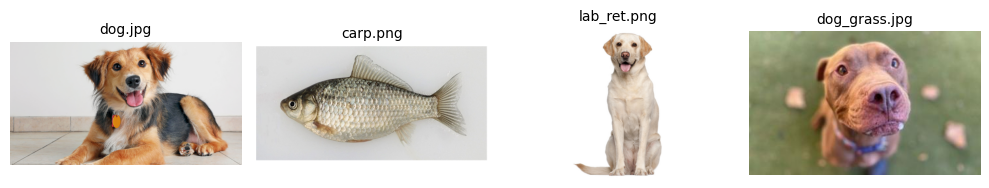

In [51]:
axes = plt.subplots(1,4, figsize=(10,10))
for i, file in enumerate(files):
  img = Image.open(file)
  plt.subplot(1, len(files), i + 1)
  plt.imshow(img)
  plt.title(os.path.basename(file), fontsize=10)
  plt.axis('off')

plt.tight_layout()
plt.show()

In [52]:
embs = []
for file in files:
  image_embedding = get_image_embedding(file)
  embs.append(image_embedding.flatten())

embs = np.array(embs)

In [18]:
embs.shape

(4, 512)

In [53]:
norms = np.linalg.norm(embs, axis=1, keepdims=True)
normalized_emb = embs / np.maximum(norms, 1e-10)  # Avoid division by zero

# Compute pairwise cosine similarity
similarity_matrix = np.dot(normalized_emb, normalized_emb.T)

In [54]:
similarity_matrix

array([[1.0000001 , 0.5084039 , 0.85618424, 0.7539673 ],
       [0.5084039 , 0.99999994, 0.5619528 , 0.43215197],
       [0.85618424, 0.5619528 , 1.0000005 , 0.70138097],
       [0.7539673 , 0.43215197, 0.70138097, 0.99999964]], dtype=float32)

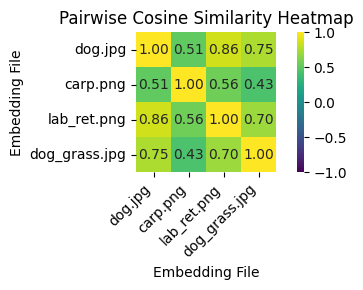

In [55]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(5, 3))
sns.heatmap(
    similarity_matrix,
    annot=True,  # Show similarity values
    cmap="viridis",  # Color map (green to yellow)
    vmin=-1, vmax=1,  # Cosine similarity range
    square=True,  # Square cells
    fmt=".2f",  # Format values to 2 decimal places
    xticklabels=files,
    yticklabels=files
)
plt.xticks(rotation=45, ha='right')
plt.title("Pairwise Cosine Similarity Heatmap")
plt.xlabel("Embedding File")
plt.ylabel("Embedding File")
plt.tight_layout()
plt.show()

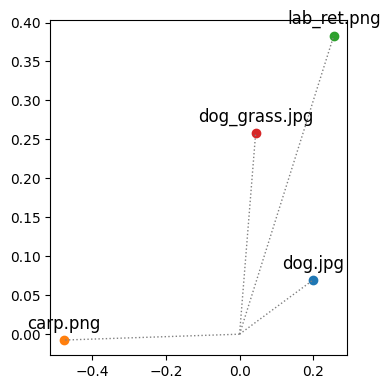

In [62]:
dim = embs.shape[1]
plt.figure(figsize=(4,4))
x, y = np.random.randint(0, dim), np.random.randint(0, dim)

for emb, file in zip(embs, files):
  plt.scatter(emb[x], emb[y], label=file)
  plt.text(emb[x], emb[y] + 0.01, file, ha='center', va='bottom', fontsize=12)
  plt.plot([0, emb[x]], [0, emb[y]], color='gray', linestyle=':', linewidth=1)

plt.tight_layout()
plt.show()